In [42]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import mne
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

**Load data from csv files.**

In [13]:
df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
df_S = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_S_feature.csv", header = 0)

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
C:\Users\sean\AppData\Local\Temp\ipykernel_24116\3915618476.py:1: SyntaxWarning: invalid escape sequence '\F'
  df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_24116\3915618476.py:2: SyntaxWarning: invalid escape sequence '\F'
  df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_24116\3915618476.py:3: SyntaxWarning: invalid escape sequence '\F'
  df_S = pd.read_csv("C:/SEAN/GA Tech Academics/

In [14]:
print(df_A.shape)

(6000, 450)


Fill in missing data with the mode of its column.

In [15]:
df_A = df_A.fillna(df_A.mode().iloc[0])
df_M = df_M.fillna(df_M.mode().iloc[0])
df_S = df_S.fillna(df_S.mode().iloc[0])

Drop the leftmost column of each dataframe because it is just an ID number.

In [16]:
df_A = df_A.iloc[:, 1:] 
df_M = df_M.iloc[:, 1:]
df_S = df_S.iloc[:, 1:]

Preprocess the data (There are 32 electrodes and 450 columns total, so 14 columns per electrode).

PCA: https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/

FFS: https://www.analyticsvidhya.com/blog/2021/04/forward-feature-selection-and-its-implementation/


In [5]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame: # COME BACK LATER
    data_arr = (data.to_numpy()).T
    channel_names = list(df_A.columns)  
    channel_types = ['eeg'] * len(channel_names) 
    info = mne.create_info(ch_names = channel_names, ch_types = channel_types)
    raw_arr = mne.io.RawArray(data_arr, info)
    raw_arr.filter(1, 40)
    
    # Perform ICA 
    ica = mne.preprocessing.ICA(n_components = 3)
    ica.fit(raw_arr)
    ica.exclude = ica.find_bads_eog(raw_arr)[0]
    raw_ica_cleaned = ica.apply(raw_arr.copy())
    
    # Convert cleaned data back into pandas DataFrame
    processed_data = (raw_ica_cleaned.get_data()).T
    df_processed = pd.DataFrame(processed_data, columns = channel_names)
    raw_ica_cleaned.plot()
    return df_processed
    

In [17]:
df_A.head()

,0.psd_delta,0.psd_theta,0.psd_alpha,0.psd_beta,0.psd_gamma,0.theta_beta_ratio,0.theta_alpha_ratio,0.alpha_beta_ratio,0.spectral_entropy_value,0.sample_entropy_value,...,31.theta_beta_ratio,31.theta_alpha_ratio,31.alpha_beta_ratio,31.spectral_entropy_value,31.sample_entropy_value,31.delta_rel_power,31.theta_rel_power,31.alpha_rel_power,31.beta_rel_power,Stress_level
0,14850.830823,14923.215094,7910.065985,6950.560915,3047.582095,2.147052,1.886611,1.138047,4.911304,2.639057,...,1.916498,1.553704,1.233503,4.733905,1.609438,0.135955,0.134893,0.206889,0.308508,1
1,14838.280527,18650.065251,7921.853628,8087.625726,2855.607519,2.306000,2.354255,0.979503,4.778889,1.098612,...,1.576940,1.477379,1.067390,4.884945,0.000000,0.152942,0.047734,0.071766,0.553523,1
2,7143.715839,16263.647994,6245.775968,4200.151132,2838.155117,3.872158,2.603944,1.487036,4.455605,0.000000,...,1.827205,1.172337,1.558600,4.681201,1.897120,0.225457,0.153719,0.120138,0.303591,1
3,7143.570136,12413.634950,7677.763201,4200.428316,2764.924613,2.955326,1.616830,1.827852,4.594508,0.000000,...,0.942636,1.648822,0.571703,4.781241,0.000000,0.166542,0.045211,0.036688,0.357148,1
4,19573.432251,18451.900407,7663.019348,6509.398324,2423.619039,2.834655,2.407915,1.177224,4.605586,1.386294,...,4.879218,3.489728,1.398166,4.639766,2.397895,0.168762,0.150286,0.064078,0.482854,1


In [21]:
print(df_A.shape)
y = df_A.iloc[:, -1]
y.head()

(6000, 449)


0    1
1    1
2    1
3    1
4    1
Name: Stress_level, dtype: int64

In [30]:
start_column_index = 0
num_features_kept = 0
kept_columns = [] # list of names of columns that are kept

for i in range(32):
    print("EEG Cap Channel #", i)
    df_subset = df_A.iloc[:, start_column_index: start_column_index + 14]
    X = df_subset
    curr_columns = X.columns
    # PCA for dimensionality reduction:
    
    # First scale the data.
    # scaler = StandardScaler()
    # scaler.fit(df_subset)
    # scaled_df_subset = scaler.transform(df_subset)
    
    # decision tree classifier
    dt_classifier = DecisionTreeClassifier()
    min_features = 1
    # recursive feature elimination with cross validation
    rfecv = RFECV(estimator = dt_classifier, min_features_to_select = min_features, cv = StratifiedKFold(), scoring = 'accuracy')
    rfecv.fit(X, y)
    
    # Obtain the kept features
    kept_columns.extend(curr_columns[rfecv.support_])
    num_features_kept += rfecv.n_features_
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Columns kept in this iteration:", curr_columns[rfecv.support_])
    
    # Now apply PCA on the scaled data.
    # pca = PCA(n_components = 2)
    # pca.fit(scaled_df_subset)
    # pca_result = pca.transform(scaled_df_subset)
    # print(pca_result.shape)
    
    start_column_index += 14

EEG Cap Channel # 0
Optimal number of features : 12
Columns kept in this iteration: Index(['0.psd_delta', '0.psd_alpha', '0.psd_beta', '0.psd_gamma',
       '0.theta_beta_ratio', '0.theta_alpha_ratio', '0.alpha_beta_ratio',
       '0.spectral_entropy_value', '0.delta_rel_power', '0.theta_rel_power',
       '0.alpha_rel_power', '0.beta_rel_power'],
      dtype='object')
EEG Cap Channel # 1
Optimal number of features : 7
Columns kept in this iteration: Index(['1.psd_delta', '1.psd_beta', '1.psd_gamma', '1.theta_alpha_ratio',
       '1.delta_rel_power', '1.theta_rel_power', '1.alpha_rel_power'],
      dtype='object')
EEG Cap Channel # 2
Optimal number of features : 9
Columns kept in this iteration: Index(['2.psd_delta', '2.psd_theta', '2.psd_beta', '2.psd_gamma',
       '2.alpha_beta_ratio', '2.spectral_entropy_value', '2.theta_rel_power',
       '2.alpha_rel_power', '2.beta_rel_power'],
      dtype='object')
EEG Cap Channel # 3
Optimal number of features : 8
Columns kept in this iteratio

In [33]:
df_A_after_rfe_1 = df_A[kept_columns]
df_A_after_rfe_1.head()

,0.psd_delta,0.psd_alpha,0.psd_beta,0.psd_gamma,0.theta_beta_ratio,0.theta_alpha_ratio,0.alpha_beta_ratio,0.spectral_entropy_value,0.delta_rel_power,0.theta_rel_power,...,29.psd_theta,29.theta_alpha_ratio,30.psd_delta,30.psd_beta,30.psd_gamma,30.alpha_beta_ratio,30.delta_rel_power,31.psd_delta,31.psd_gamma,31.alpha_beta_ratio
0,14850.830823,7910.065985,6950.560915,3047.582095,2.147052,1.886611,1.138047,4.911304,0.059237,0.199444,...,11599.479835,0.763322,37558.807843,14730.332852,4509.043594,1.233503,0.135955,37558.807843,4509.043594,1.233503
1,14838.280527,7921.853628,8087.625726,2855.607519,2.306000,2.354255,0.979503,4.778889,0.150847,0.134471,...,22775.412626,1.848965,25393.066093,16442.640776,6048.403794,1.067390,0.152942,25393.066093,6048.403794,1.067390
2,7143.715839,6245.775968,4200.151132,2838.155117,3.872158,2.603944,1.487036,4.455605,0.082685,0.319816,...,13887.994487,1.066027,38260.713533,13415.290217,5266.032737,1.558600,0.225457,38260.713533,5266.032737,1.558600
3,7143.570136,7677.763201,4200.428316,2764.924613,2.955326,1.616830,1.827852,4.594508,0.032636,0.173594,...,10228.103954,1.446122,39747.338994,16653.354116,5675.304341,0.571703,0.166542,39747.338994,5675.304341,0.571703
4,19573.432251,7663.019348,6509.398324,2423.619039,2.834655,2.407915,1.177224,4.605586,0.198891,0.162208,...,25034.980813,2.401818,70894.563410,11186.637674,5413.338752,1.398166,0.168762,70894.563410,5413.338752,1.398166


In [31]:
print("number of features kept: ", num_features_kept)

number of features kept:  208


Perform recursive feature elimination again, but this time on all the kept features.

Number of principal components to keep 80% of variance:  50


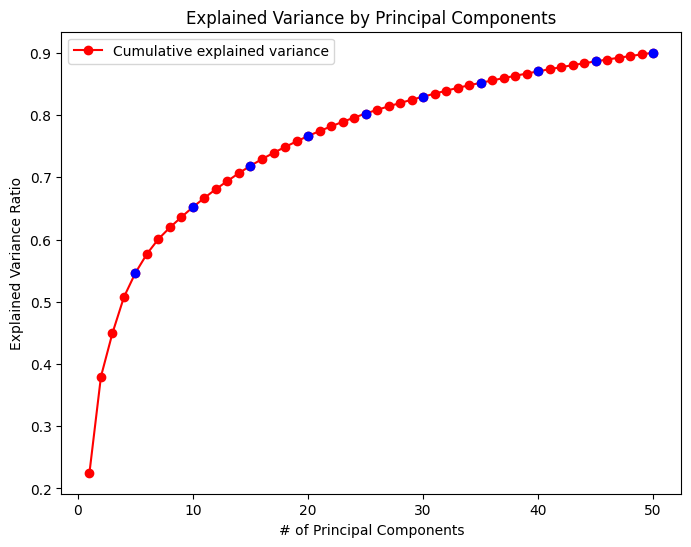

In [53]:
X = df_A_after_rfe_1
curr_columns = X.columns

# PCA for dimensionality reduction:

# First scale the data.
scaler = StandardScaler()
scaler.fit(X)
scaled_X= scaler.transform(X)

# Perform PCA
pca = PCA(n_components = 50)
pca.fit(scaled_X)
pca_result = pca.transform(scaled_X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
num_pc = np.argmax(cumulative_variance_ratio >= 0.8) + 1
print("Number of principal components to keep 80% of variance: ", num_pc)

# Visualization
plt.figure(figsize=(8, 6))

# Line plot for cumulative explained variance (all points are initially red)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='red',
         label='Cumulative explained variance', linestyle='-')

# Add blue markers for every n-th point where n is divisible by 5
for i in range(5, len(cumulative_variance_ratio) + 1, 5):
    plt.scatter(i, cumulative_variance_ratio[i - 1], color='blue', zorder=5) 
plt.xlabel('# of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()

In [26]:
df_subset = df_A.iloc[:, :-1]
X = df_subset

# decision tree classifier
dt_classifier = DecisionTreeClassifier()
min_features = 1
# recursive feature elimination with cross validation
rfecv = RFECV(estimator = dt_classifier, min_features_to_select = min_features, cv = StratifiedKFold(), scoring = 'accuracy')
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

KeyboardInterrupt: 

After performing dimensionality reduction, visualize the remaining features.